In [174]:
#Logica das gates
from ortools.linear_solver import pywraplp
import random
from random import choices


    
    
def fatoriza(n):
    i = 1
    s = n
    res = []
    while s > 0:
        if i < s:
            res.append(i)
        else:
            res.append(s)
        s = s-i
        i = i+1
    return res

def tipo(ands,nodos_f,flagN):
    typ = ['o','a','n']
    ti = ''
    
    # caso os n de nodos que falta é igual a o numero de ands que faltam tem
    # ser obrigatoriamente ands
    if ands == nodos_f:
        ti = 'a'
    
    # caso nao pode ser n
    elif flagN == True:
        # caso n possa ser um and (a), logo so pode ser um or
        if ands == 0:
            ti = 'o'
        
        # ands > entao pode ser um and ou um or
        else:
            ti = random.choice(['o','a'])
    
    # caso sejam esgotados as gates and (a)
    elif ands == 0:
        ti = random.choice(['o','n'])

    # generico pode ser qualquer gate
    else:
        ti = random.choice(['o','a'])
    
    nodos_f = nodos_f-1
    if ti == 'a':
        ands= ands-1
    return (ti,ands,nodos_f)



def camadas(camada_d,camada_o,inp,graph,N,M,adds):
    cam_d = camada_d[:]
    cam_o = camada_o[:]
    r = True
    
    for node_dest in cam_d:
        ti = 'i'
        
        # caso esteja no ultimo nodo e todos os anteriore sejam == n
        # este ultimo nodo tem de ser necessariamente ou um or ou uma and
        # caso seja a primeira camada excluindo a camada dos inputs
        # o caso final tambem esta incuido pois cam_d= [n], cam_d[0] == cam_d[-1]
        if node_dest == cam_d[-1] and r:
            ti,adds,M = tipo(adds,M,True)
            graph.nodes[node_dest]['tipo'] = ti
            # logo tem de ter duas origens
            o1 = randO(cam_o,inp,N)
            o2 = randO(cam_o,inp,N)
            graph.add_edges_from([(o1 ,node_dest),\
                                  (o2 ,node_dest)])
        # caso generico
        else:
            ti,adds,M = tipo(adds,M,False)
            graph.nodes[node_dest]['tipo'] = ti
            # caso o ou a
            if ti != 'n':
                r = False
                o1 = randO(cam_o,inp,N)
                o2 = randO(cam_o,inp,N)
                
                #caso randO([],[],N) ele pode ficar com o1 == o2 e nx n adiciona uma transição
                while o1 == o2:
                    o2 = randO(cam_o,inp,N)
                

                graph.add_edges_from([(o1 ,node_dest),\
                                      (o2 ,node_dest)])
            # caso n
            else:
                o1 = randO(cam_o,inp,N)
                graph.add_edge(o1 ,node_dest)
                
    return M,adds
def colorG(G):
    color_map = []
    for node in G:
        node_type = G.nodes[node]['tipo']
        if node_type == 'n':
            color_map.append('red')
        elif node_type == 'i': 
            color_map.append('grey') 
        elif node_type == 'o':
            color_map.append('#00d9d2')
        elif node_type == 'a':
            color_map.append('#d9cb00')
        elif node_type == 'w':
            color_map.append('#ffa500')
        else:
            color_map.append('#ffc0cb')
    return color_map



def randO(lisa,lisb,N):
    if len(lisa) == 0:
        if len(lisb) == 0:
            return random.randint(0,N-1)
        else:
            o = random.choice(lisb)
            lisb.remove(o)
            return o
    else:
        o = random.choice(lisa)
        lisa.remove(o)
        return o

In [334]:
import math
import itertools
import pprint
import networkx as nx
from random import randint
#N -> numero de nodos input; M-> numero gates; gamma -> percentagem gates AND
def geraCirc(N,M,gamma):
    #M = randint((N)**2,(N)**3)
    ands = math.ceil(2*M*gamma)
    
    G = nx.DiGraph(directed=True)
    #Criar os nodos de input
    G.add_nodes_from([ (i, {"tipo": 'i'}) for i in range(N)])
    #print(G.nodes(0))
    #Atualizar a contagem dos nodos
    node_counter = N
    
    nodosGate = fatoriza(M)
    
    ncamadas = len(nodosGate)
    
    dic_camada = {}
    
    inputs = [i for i in range(N)]
    
    for camada in range(ncamadas):
        currcamada = ncamadas - camada
        dic_camada[currcamada] = []
        
        for nnodos in range(nodosGate[camada]):
            G.add_node(node_counter)
            dic_camada[currcamada].append(node_counter)
            node_counter = node_counter + 1
            
    #adicionar tipos e ligacoes
    for camada in dic_camada:
        if camada == 1:
            M,ands = camadas(dic_camada[camada],[i for i in range(N)],inputs,G,N,M,ands)
        else:
            M,ands = camadas(dic_camada[camada],dic_camada[camada-1],inputs,G,N,M,ands)
    #dic = graph_dic(G,dic_camada,N)
    for nodo in range(len(G.nodes())):
        if G.nodes[nodo]['tipo'] != 'i':
            for descendente in G.adj[nodo]:
                G.add_nodes_from([node_counter],tipo = "w",val=None)
                G.add_edge(nodo,node_counter)
                G.add_edge(node_counter,descendente)
                G.remove_edge(nodo,descendente)
                node_counter = node_counter + 1
                break
        if G.adj[nodo] == {}:
                G.add_nodes_from([node_counter],tipo = "output",val=None)
                G.add_edge(nodo,node_counter)
                node_counter = node_counter + 1
        
    
        
        
        
        
    pos = nx.spring_layout(G)
    nx.draw(G,pos,with_labels=True,node_size = 600,node_color = colorG(G))
    
    
   
    return G

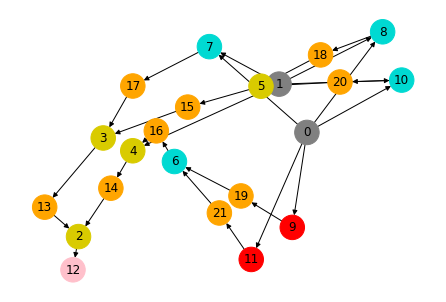

In [338]:
N = 2
M = 10
gamma = 0.2

cir = geraCirc(N,M,gamma)

In [339]:
def calcula(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    ligacoes = [i for i in G.nodes if G.nodes[i]["tipo"]=='i' or G.nodes[i]["tipo"]=='w']
    
    gates = [i for i in G.nodes if G.nodes[i]["tipo"]=='o' or G.nodes[i]["tipo"]=='a' or G.nodes[i]["tipo"]=='n']
    dic={}
    for i in G:
        if G.nodes[i]["tipo"] == 'output':
            
            dic[i] = solver.BoolVar(str(i))
            
            solver.Add(dic[i] == 1)
            
    ninputs = 0
    for i in G:
        if G.nodes[i]["tipo"] == 'i':
            ninputs+=1
            
            
    
    for ligacao in ligacoes:
        dic[ligacao]=solver.BoolVar(str(ligacao))
    
    for gate in gates:
        antecessores = [i for i in G.predecessors(gate)]
        sucessores =[i for i in G.successors(gate)]
        sucessores = sucessores[0]
        
        
        
        if G.nodes[gate]["tipo"] == 'a':
            for x in antecessores:
                solver.Add(dic[x]>=dic[sucessores])
            solver.Add(sum([dic[a] for a in antecessores])<= dic[sucessores]+len(antecessores)-1)
            
            
        elif G.nodes[gate]["tipo"] == 'o':
            for x in antecessores:
                
                
                solver.Add(dic[x]<=dic[sucessores])
            solver.Add(sum([dic[a] for a in antecessores]) >= dic[sucessores])
            
            
        elif G.nodes[gate]["tipo"] == 'n':
            
            antecessores=antecessores[0]
            solver.Add(dic[antecessores] + dic[sucessores] == 1)
    
    solver.Maximize(sum(dic[i] for i in range(ninputs)))
    if solver.Solve()==pywraplp.Solver.OPTIMAL:
        for i in dic:
            G.nodes[i]["tipo"] = round(dic[i].solution_value())
        resultado = [G.nodes[i]["tipo"] for i in range(ninputs)]
        print('Resultado: ' + str(resultado))
        if solver.NextSolution():
            
            res2=[round(dic[i].solution_value()) for i in range(ninputs)]
            if res2 == resultado:
                print('Nao existe outra solucao!')
            else:
                print('Mais proximo: '+str(res2))
        else:
            print('Nao existe outra solucao!')
    else:
        print('Nao existe input que tenha output 1')

In [340]:
calcula(cir)

Resultado: [0, 1]
Nao existe outra solucao!
